# Multi-State Model first example

## In this notebook

This notebook provides a simple setting which illustrates basic usage of the model.

## Typical settings

In a typical setting of modelling patient illness trajectories, there are multiple sources of complexity:

1. There could be many states (mild, severe, recovered, released from hospital, death etc.)
2. The probability of each transition and the duration of the stay in each state depend on patient covariates.
3. Patient covariates can change over time, possibly in a manner which depends on the states visited.

In order to introduce the multi-state-model we shall use a much simpler setting where our data arrives from a simple 3 state model and covariates do not change over time or affect the probabilities of transitions between states.

## A Simple Multi-State Setting

Patients start at state 1, state 3 shall be a terminal state and states 1,2 shall be identical in the sense that from both:

1. With probability 1/2 you transition to state 3 within 1 day.
2. With probability 1/2 you transition to state 2 or 1 (depending on the present state), within $t∼exp(λ)$

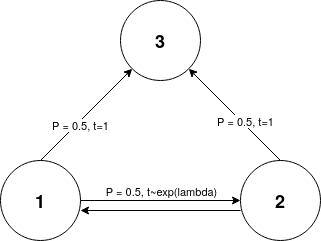

In [1]:
from IPython.display import Image
Image(filename='toy_setting.png')

A simple Multi-State Model

For this setting, one can show that the expected time until reaching a terminal state is $1+\frac{1}{λ}$ (see proof at the end of this notebook.)

## The Dataset Structure

Let’s load the dataset, which was constructed based on the graph above

In [2]:
from pymsm.examples.first_example_utils import create_toy_setting_dataset
dataset = create_toy_setting_dataset(lambda_param=2)
print('dataset type: {}'.format(type(dataset)))
print('elemnets type: {}'.format(type(dataset[0])))

dataset type: <class 'list'>
elemnets type: <class 'pymsm.multi_state_competing_risks_model.PathObject'>


The dataset is a list of elements from class PathObject. Each PathObject in the list corresponds to a single sample’s (i.e “patient’s”) observed path. Let’s look at one such object in detail:

In [3]:
first_path = dataset[0]
print(type(first_path))

print('\n------covariates------')
print(first_path.covariates)

print('\n-------states---------')
print(first_path.states)

print('\n--time at each state--')
print(first_path.time_at_each_state)

print('\n------sample id-------')
print(first_path.sample_id)

<class 'pymsm.multi_state_competing_risks_model.PathObject'>

------covariates------
a   -0.669272
b    0.884765
dtype: float64

-------states---------
[1, 2, 3]

--time at each state--
[0.4078647886081198, 1]

------sample id-------
0


We see the following attributes:

1. *covariates* : These are the sample’s covariates. In this case they were randomally generated and do not affect the state transitions, but for a patient this could be a numerical vector with entries such as:
    * “age in years”
    * “is male”
    * “number of days that have passed since hospitalization”
    * etc..
2. *states* : These are the observed states the sample visited, encoded as positive integers. Here we can see the back and forth between states 1 and 2, ending with the only terminal state (state 3).
3. *time_at_each_state* : These are the observed times spent at each state.
4. *sample_id* : (optional) a unique identifier of the patient.

Note: if the last state is a terminal state, then the vector of times should be shorter than the vector of states by 1. Conversely, if the last state is not a terminal state, then the length of the vector of times should be the same as that of the states. In such a case, the sample is inferred to be right censored.

## Updating Covariates Over Time

In order to update the patient covariates over time, we need to define a state-transition function.
In this simple case, the covariates do not change and the function is trivial

In [4]:
def default_update_covariates_function(covariates_entering_origin_state, origin_state=None, target_state=None,
                                       time_at_origin=None, abs_time_entry_to_target_state=None):
    return covariates_entering_origin_state

You can define any function, as long as it recieves the following parameter types (in this order): 
1. pandas Series (sample covariates when entering the origin state)
2. int (origin state number)
3. int (target state number)
4. float (time spent at origin state)
5. float (absolute time of entry to target state)

If some of the parameters are not used in the function, use a default value of None, as in the example above.

## Defining terminal states

In [5]:
terminal_states = [3]

## Fitting the model

Import and init the Model

In [6]:
from pymsm.multi_state_competing_risks_model import MultiStateModel
multi_state_model = MultiStateModel(dataset, terminal_states, default_update_covariates_function, 
                                    ['covariate_1', 'covariate_2'])

Fit the Model

In [7]:
multi_state_model.fit()

Fitting Model at State: 1
>>> Fitting Transition to State: 2, n events: 702
>>> Fitting Transition to State: 3, n events: 674
Fitting Model at State: 2
>>> Fitting Transition to State: 3, n events: 326
>>> Fitting Transition to State: 1, n events: 376


## Making predictions  

Predictions are done via monte carlo simulation. Initial patient covariates, along with the patient’s current state are supplied. The next states are sequentially sampled via the model parameters. The process concludes when the patient arrives at a terminal state or the number of transitions exceeds the specified maximum.

In [8]:
import numpy as np

all_mcs = multi_state_model.run_monte_carlo_simulation(
              # the current covariates of the patient. 
              # especially important to use updated covariates in case of
              # time varying covariates along with a prediction from a point in time 
              # during hospitalization
              sample_covariates = np.array([0.2,-0.3]), 
              
              # in this setting samples start at state 1, but
              # in general this can be any non-terminal state which
              # then serves as the simulation starting point
              origin_state = 1, 
              
              # in this setting we start predictions from time 0, but 
              # predictions can be made from any point in time during the 
              # patient's trajectory
              current_time = 0,   
              
              # If there is an observed upper limit on the number of transitions, we recommend
              # setting this value to that limit in order to prevent generation of outlier paths
              max_transitions = 100,
              
              # the number of paths to simulate:
              n_random_samples = 1000)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 232.83it/s]


## The Simulation Results Format:  

Each run is described by a list of states and times spent at each state (same format as the dataset the model is fit to).

In [9]:
mc = all_mcs[0]
print(mc.states)
print(mc.time_at_each_state)

mc = all_mcs[1]
print(mc.states)
print(mc.time_at_each_state)

[1, 2, 1, 3]
[3.2023886466379428, 0.9495424935730798, 0.15962949075341282]
[1, 2, 1, 3]
[1.8968554459242266, 1.6332968427722088, 2.7134405014544503]


## Analyzing The Results  

Recall we could compute the expected time for this simple setting? We will now see that the model provides an accurate estimate of this expected value of $1+\frac{1}{\lambda}$

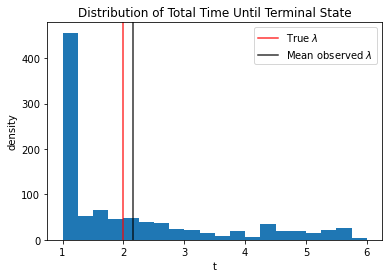

In [10]:
from pymsm.examples.first_example_utils import plot_total_time_until_terminal_state

plot_total_time_until_terminal_state(all_mcs, true_lambda=2)

## Conclusions

This notebook provides a simple example usage of the multi-state model, beginning with the structure of the dataset used to fit the model and up to a simple analysis of the model’s predictions.

By following this process you can fit the model to any such dataset and make predictions

## Appendix 1 - Demonstrating that the expected time until reaching the terminal state is $1+\frac{1}{λ}$

Let T be the random variable denoting the time until reaching the terminal state #3, and let $S2$ be the random variable denoting the second state visited by the sample (recall all patients start at state 1, that is: $S1=1$).
From the law of total expectation:

\begin{equation}
\mathbf{E}[T] = \mathbf{E}[\mathbf{E}[T|S_2]] = \mathbf{P}(S_2 = 3)\cdot\mathbf{E}[T|S_2 = 3] + \mathbf{P}(S_2 = 2)\cdot\mathbf{E}[T|S_2 = 2]
\end{equation}

Denote $T=T_1+T_{2^+}$ (“The total time is the sum of the time of the first transition plus the time from arrival to the second state onwards”). Then:

\begin{equation}
=\frac{1}{2}\cdot1 + \frac{1}{2}\cdot\mathbf{E}[T_1 + T_{2^+}|S_2 = 2] = \frac{1}{2}+\frac{1}{2}\cdot(\mathbf{E}[T_1|S_2 = 2] + \mathbf{E}[T_{2^+}]|S_2 = 2) \\= \frac{1}{2}\cdot1 + \frac{1}{2}\cdot(\frac{1}{λ}+\mathbf{E}[T])
\end{equation}

We then have:

\begin{equation}
2\cdot\mathbf{E}[T] = 1 + (\frac{1}{λ} + \mathbf{E}[T])
\end{equation}

and:

\begin{equation}
{E}[T] = 1 + \frac{1}{λ}
\end{equation}